### Импорты


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

%matplotlib inline

In [ ]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Данные

In [ ]:
ads = pd.read_csv('ads.csv', index_col=['Time'], parse_dates=['Time']) # Просмотры рекламы за час
currency = pd.read_csv('currency.csv', index_col=['Time'], parse_dates=['Time']) # Трата внутриигровой валюты в день

In [ ]:
ads.head()

Ads
Time                       
2017-09-13 00:00:00   80115
2017-09-13 01:00:00   79885
2017-09-13 02:00:00   89325
2017-09-13 03:00:00  101930
2017-09-13 04:00:00  121630

In [ ]:
currency.head()

GEMS_GEMS_SPENT
Time                       
2017-05-01          1199436
2017-05-02          1045515
2017-05-03           586111
2017-05-04           856601
2017-05-05           793775

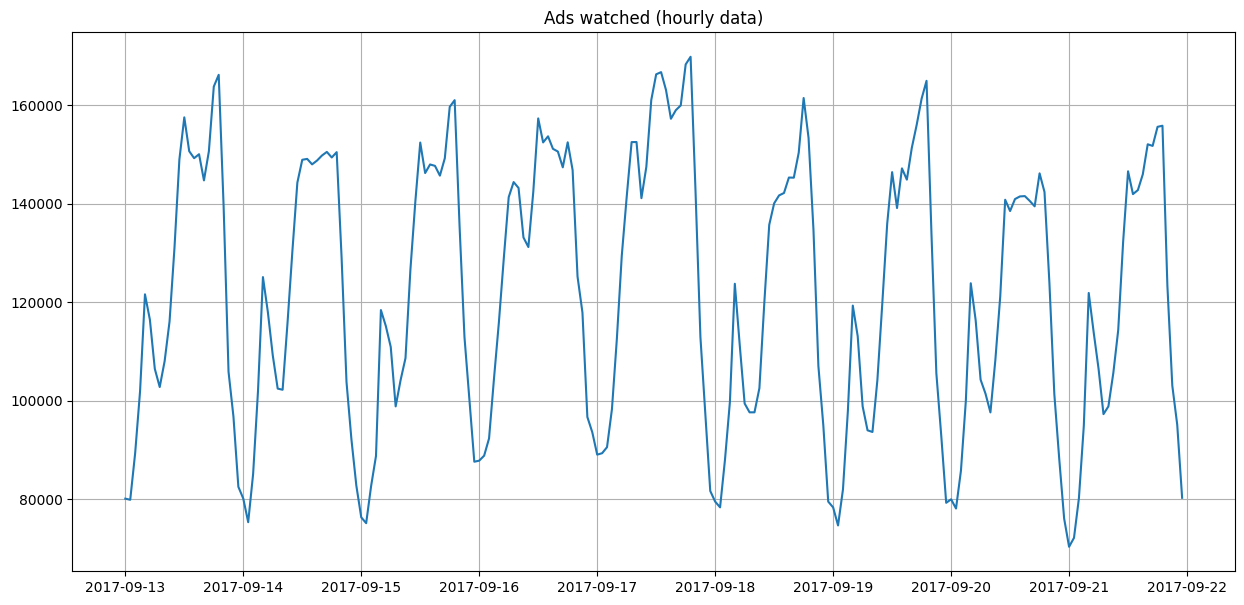

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

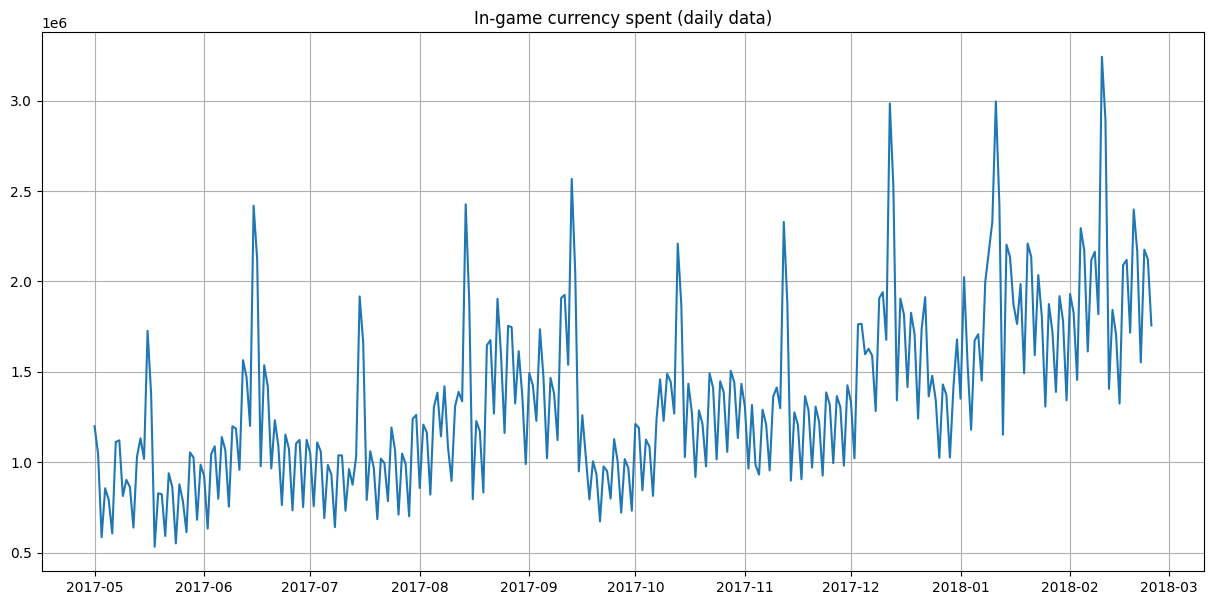

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

### Скользящее среднее



$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [ ]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(ads, 24) # prediction for the last observed day (past 24 hours)

116805.0

In [ ]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        print(f'MAE: {mae}')
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

Сглаживание с окном 4

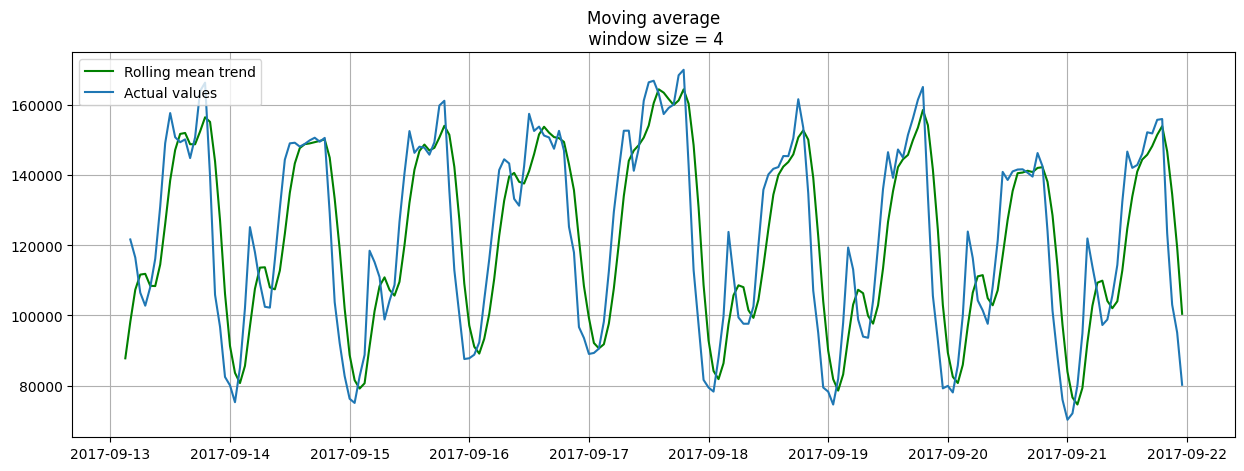

In [ ]:
plotMovingAverage(ads, 4)

Сглаживание с окном 12

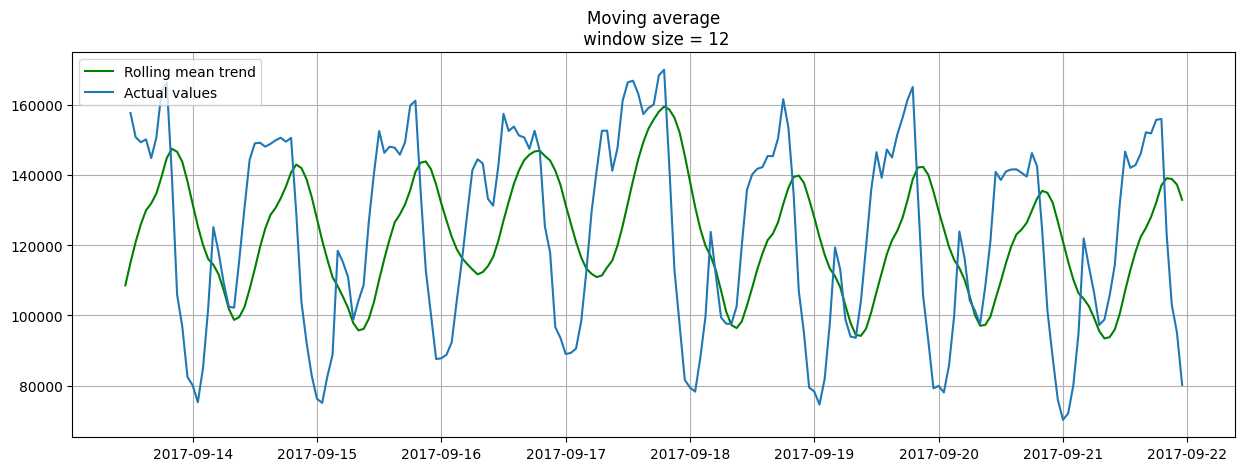

In [ ]:
plotMovingAverage(ads, 12)

Сглаживание с окном 24 - дневной тренд

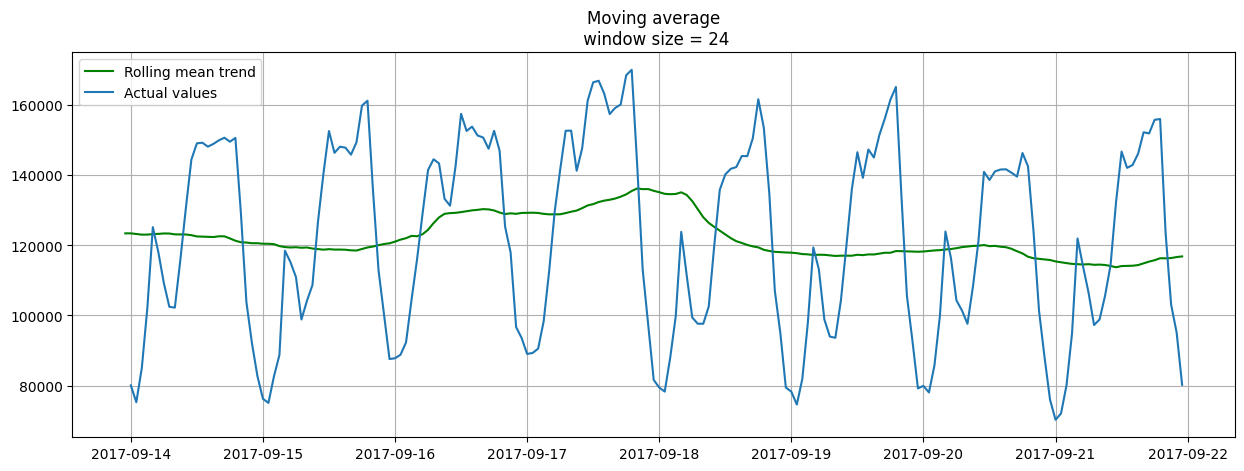

In [ ]:
plotMovingAverage(ads, 24)

Добавим доверительные интервалы

MAE: 11397.688679245282


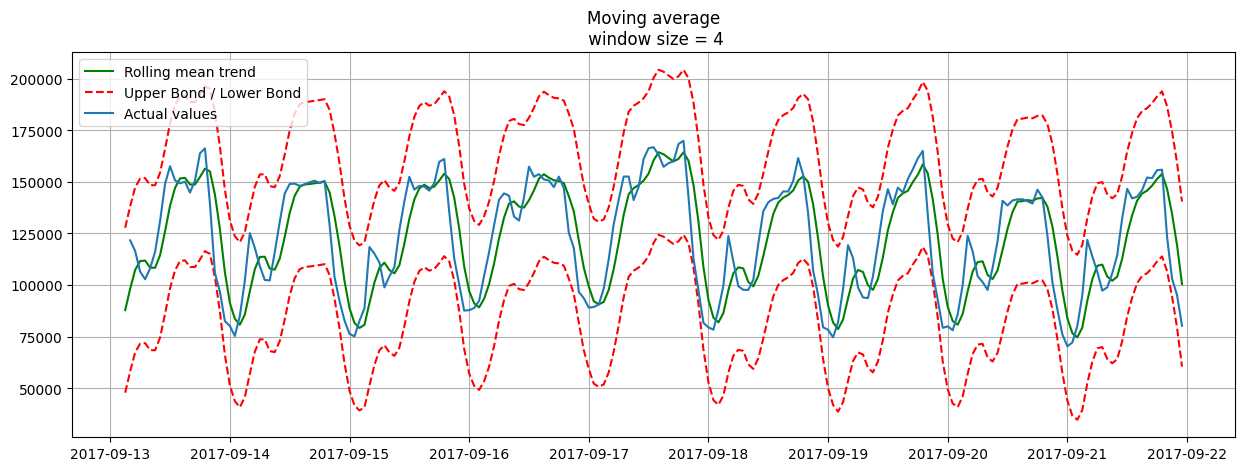

In [ ]:
plotMovingAverage(ads, 4, plot_intervals=True)

#### Детекция аномалий

Добавим вручную аномалию


In [ ]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2 # say we have 80% drop of ads

MAE: 11662.639150943396


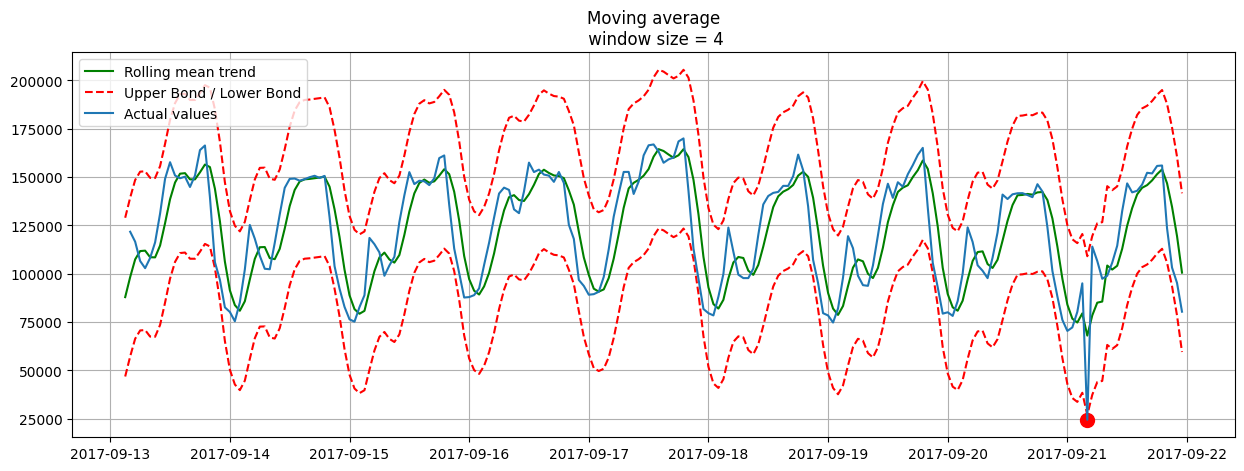

In [ ]:
plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

Проверим на втором временном ряду

MAE: 236578.0672842516


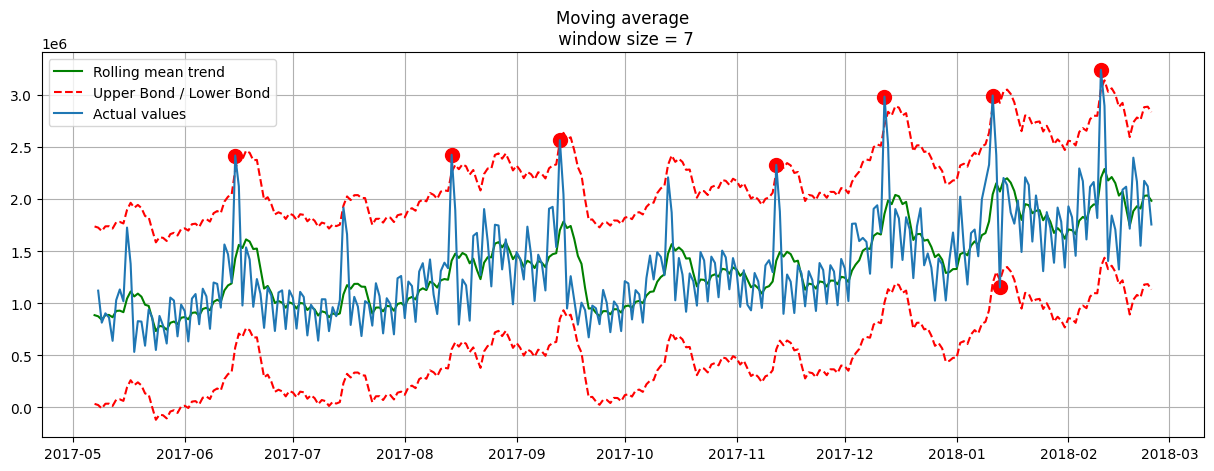

In [ ]:
plotMovingAverage(currency, 7, plot_intervals=True, plot_anomalies=True)

Каждый 30-дневный пик отмечен как аномалия...

### Взвешенное скользящее среднее


$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

In [ ]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [ ]:
weighted_average(ads, [0.6, 0.3, 0.1])

87025.5

### Экспоненциальное сглаживание

В этом подхоже мы экспоненциально уменьшаем веса по мере продвижения назад во времени.
$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Вес $\alpha$ называется коэффициентом сглаживания. Он определяет, насколько быстро мы «забудем» последнее доступное истинное наблюдение. Чем меньше $\alpha$, тем большее влияние оказывают предыдущие наблюдения и тем более гладким является ряд.

Экспоненциальность скрыта в рекурсивности функции - мы каждый раз умножаем на $(1-\alpha)$, что уже содержит умножение на $(1-\alpha)$ предыдущих значений.

In [ ]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [ ]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas

        series - dataset with timestamps
        alphas - list of floats, smoothing parameters

    """
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

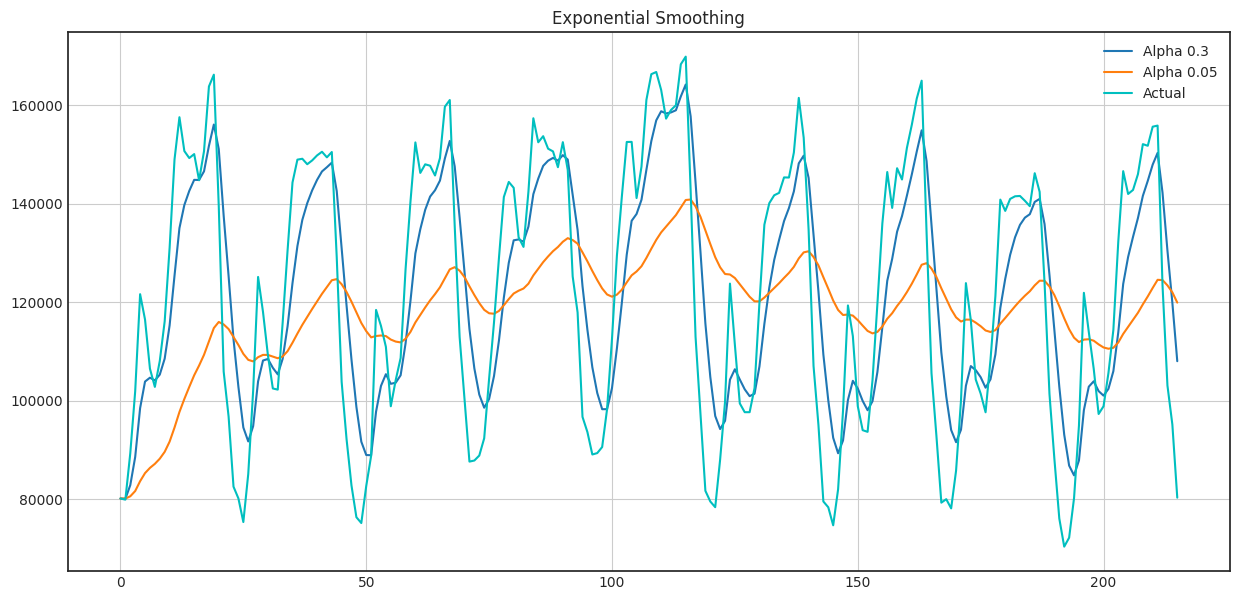

In [ ]:
plotExponentialSmoothing(ads.Ads, [0.3, 0.05])

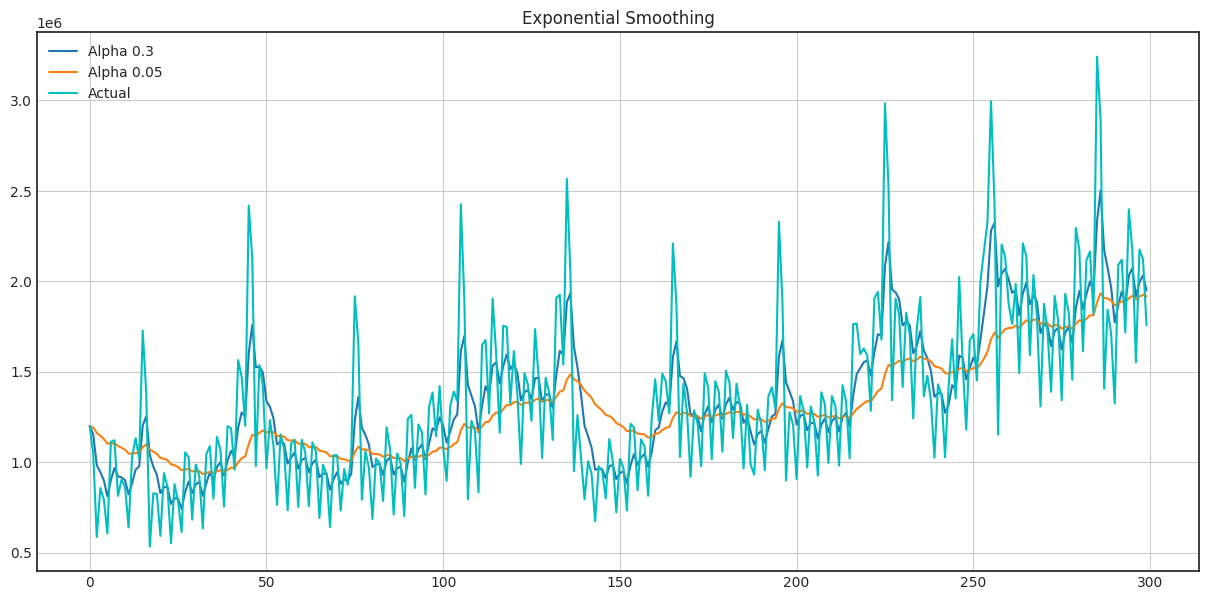

In [ ]:
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

### Time-series cross validation



<img src="https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png"/>

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

### Статистические модели

#### Стационарность

В чем проблема в этих рядах?

<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png"/>


<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png"/>


<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png"/>


#### Белый шум

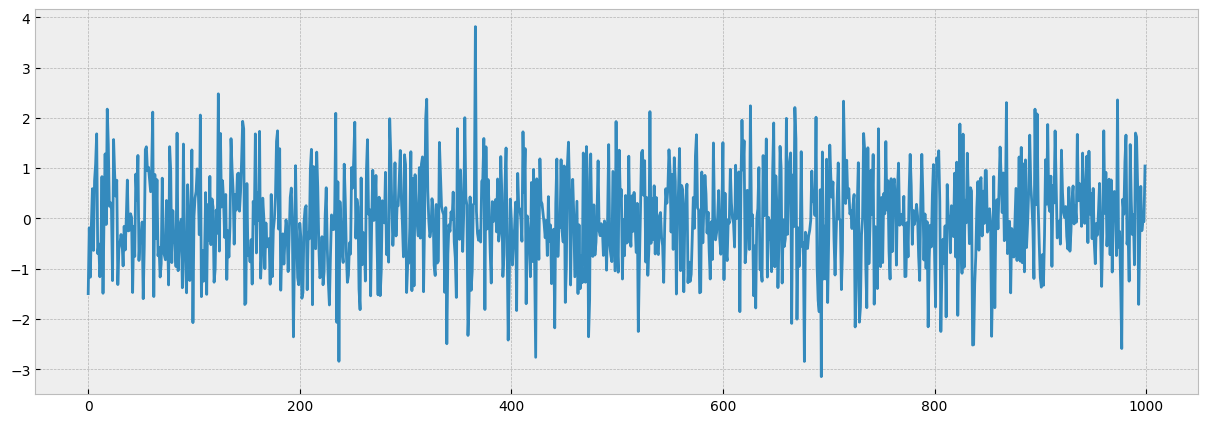

In [ ]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

Here is the code to render the plots.

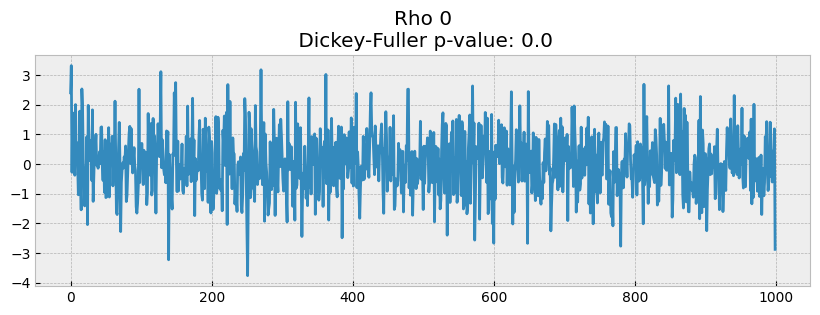

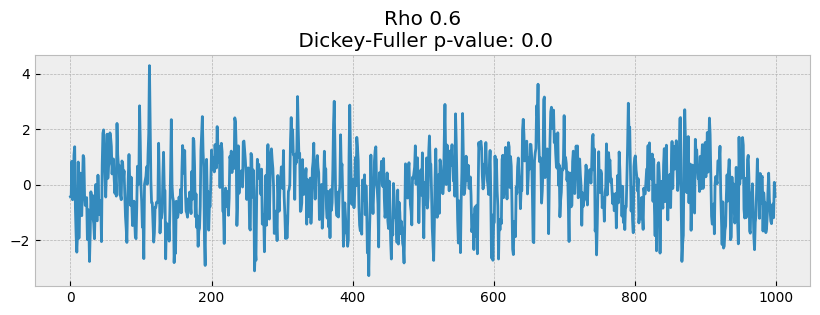

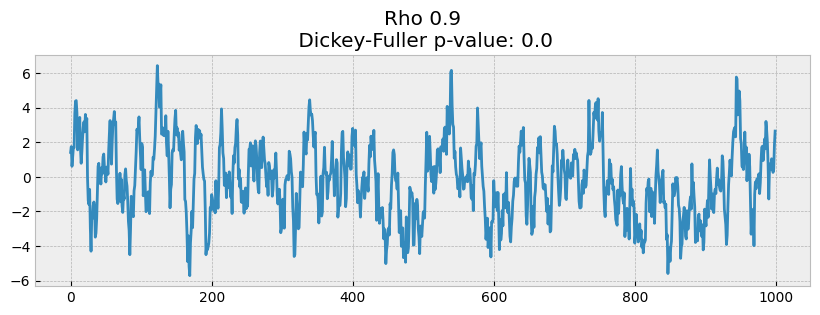

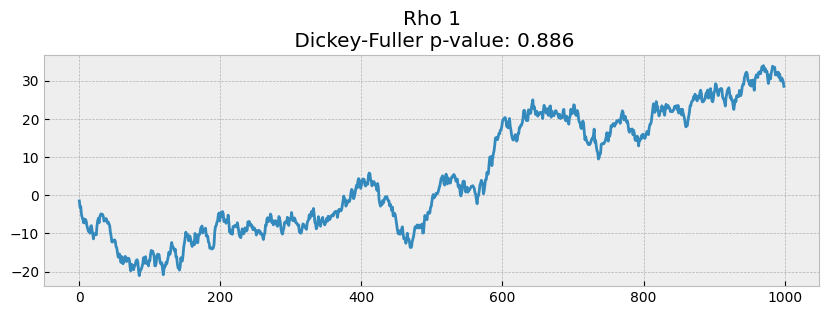

In [ ]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))

for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

#### Тест Дики-Фуллера

(Dickey-Fuller test)

- Нулевая гипотеза предполагает, что процесс нестационарный
- Альтернативная гипотеза соответственно говорит об обратном
- Для принятия решения смотрим на p-value


#### Избавляемся от нестационарности и строим ARIMA

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

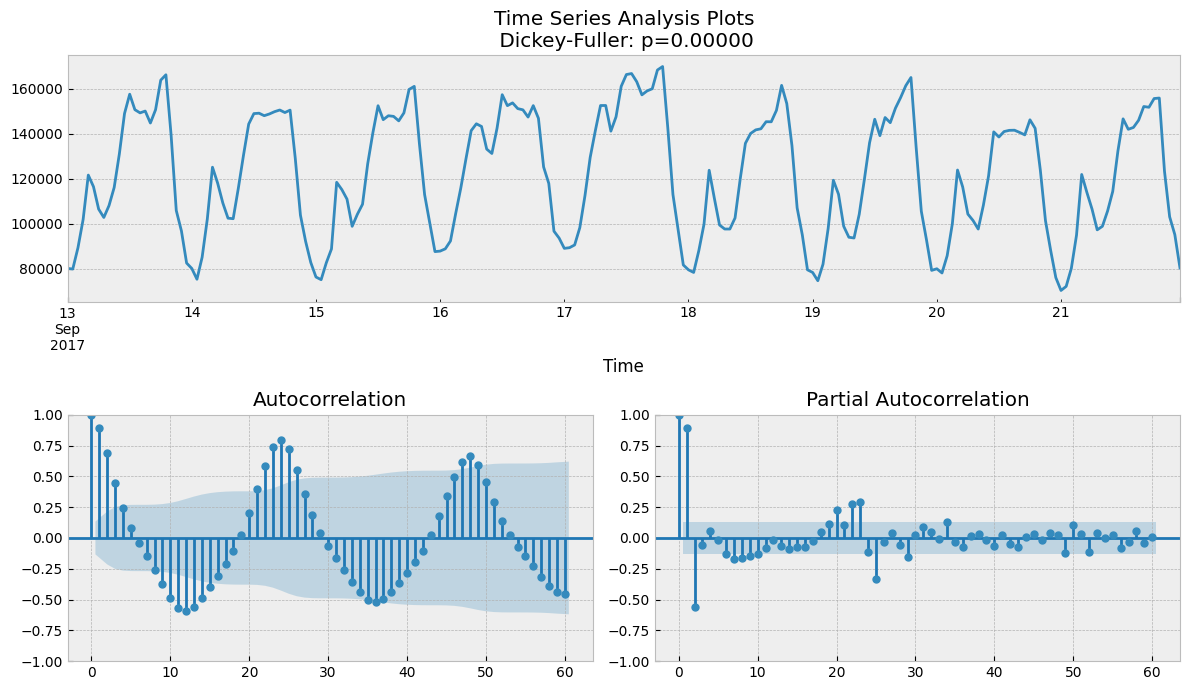

In [ ]:
tsplot(ads.Ads, lags=60)

С рядом почти все хорошо, но есть сезонность - избавимся от нее, вычитая сезонные лаги

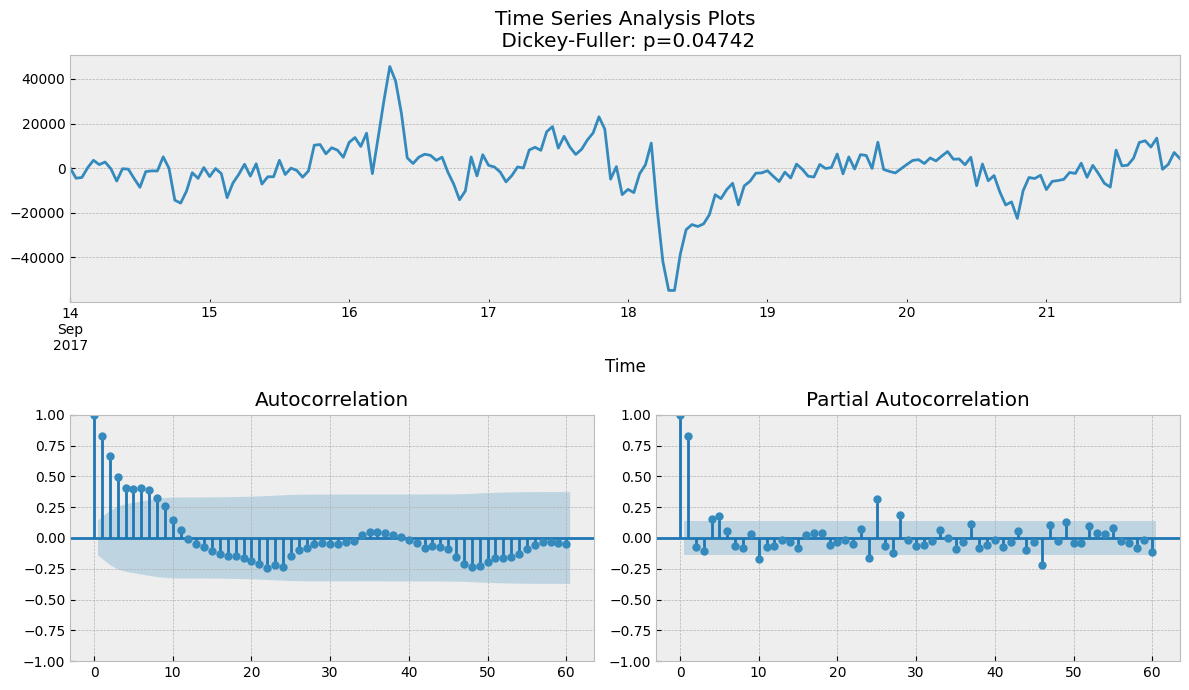

In [ ]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

Все стало намного лучше, но автокорреляционная функция по-прежнему имеет слишком много значительных лагов. Чтобы их удалить, проведем **дифференцирование**

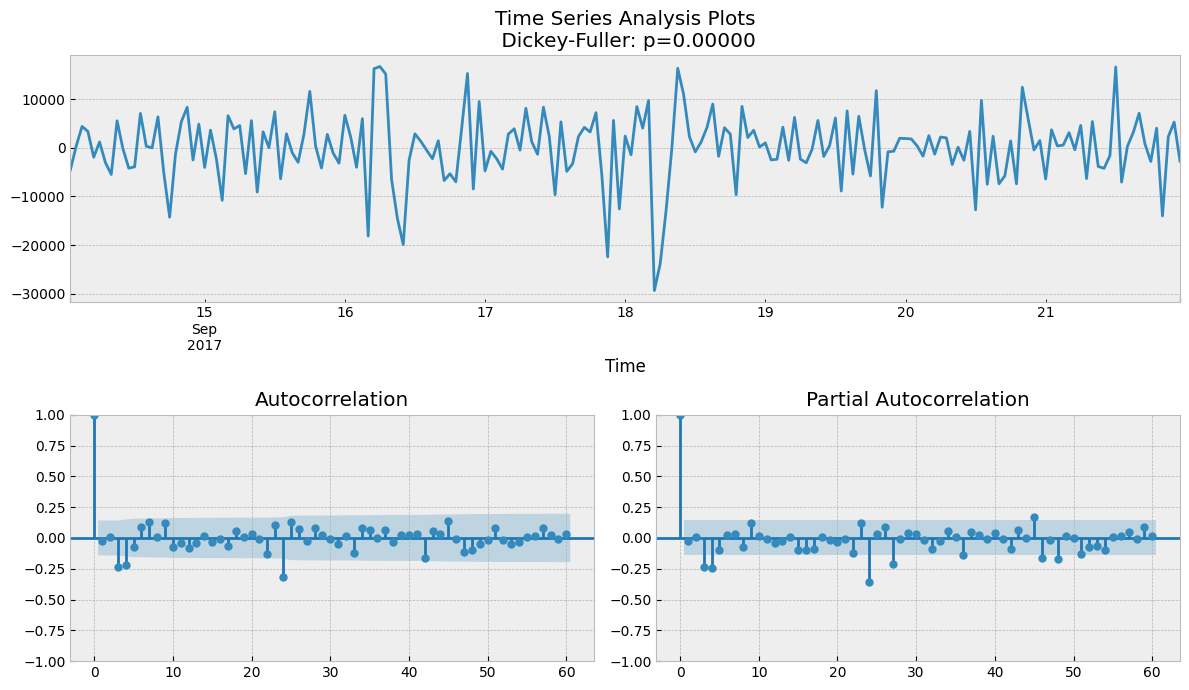

In [ ]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

#### Вспоминаем ARIMA и еще кое-что

$SARIMA(p, d, q)(P, D, Q, s)$ - модель сезонной авторегрессии скользящего среднего:

- $AR(p)$ - модель авторегрессии, т.е. регрессия временного ряда на самого себя. Основное предположение состоит в том, что значения текущего ряда зависят от его предыдущих значений с некоторым лагом (или несколькими лагами). Максимальный лаг в модели обозначается как $p$. Чтобы определить начальный $p$, нужно посмотреть на график PACF и найти самый большой значимый лаг, после которого **большинство** других лагов становятся незначительными.
- $MA(q)$ - модель скользящего среднего. Ммоделируем ошибку временного ряда, опять же с предположением, что текущая ошибка зависит от предыдущей с некоторой задержкой, которая называется $q$. Начальное значение можно найти на графике ACF, используя ту же логику, что и раньше.

$AR(p) + MA(q) = ARMA(p, q)$


- $I(d)$ - порядок интегрирования. Это просто число несезонных различий, необходимое для того, чтобы ряд стал стационарным. В нашем случае это всего лишь 1, потому что мы использовали первые разности.

- $S(s)$ - отвечает за сезонность и равен длине сезонного периода ряда.

При этом у нас есть три параметра: $(P, D, Q)$

- $P$ - порядок авторегрессии для сезонной составляющей модели, который можно получить из PACF. Но нужно смотреть на количество значительных лагов, кратных продолжительности сезона. Например, если период равен 24 и мы видим, что 24-й и 48-й лаги значимы в PACF, это означает, что начальный $P$ должен быть равен 2.

- $Q$ - аналогичная логика с использованием вместо этого графика ACF.

- $D$ - порядок сезонного интегрирования. Оно может быть равно 1 или 0, в зависимости от того, применялись ли сезонные разницы или нет.

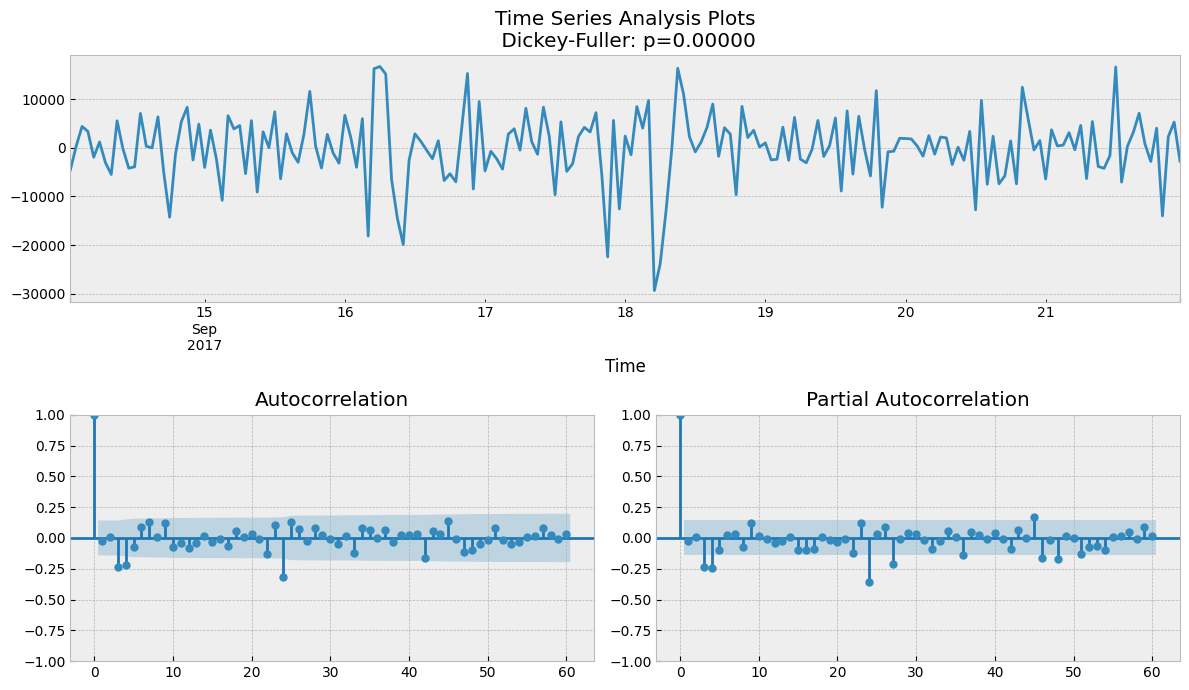

In [ ]:
tsplot(ads_diff[24+1:], lags=60)

- $p$, скорее всего, равен 4, поскольку это последнее значительное отставание PACF, после которого большинство других не являются значимыми.
- $d$ равен 1 - порядок дифференцирования
- $q$ должно быть где-то около 4, как видно на ACF.
- $P$ может быть 2, так как 24-й и 48-й лаги на PACF отчасти значительны.
- $D$ снова равен 1, потому что мы провели сезонное дифференцирование
- $Q$, вероятно, равен 1. 24-й лаг по ACF значителен, а 48-й - нет.

Проверим разные варианты

In [ ]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1
qs = range(2, 5)
Ps = range(0, 2)
D=1
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [ ]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

In [ ]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: user 6min 16s, sys: 1.63 s, total: 6min 17s
Wall time: 3min 43s


In [ ]:
result_table.head()

parameters          aic
0  (2, 3, 1, 1)  3888.642174
1  (3, 2, 1, 1)  3888.763568
2  (4, 2, 1, 1)  3890.279740
3  (3, 3, 1, 1)  3890.513196
4  (2, 4, 1, 1)  3892.302849

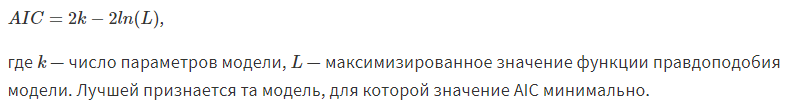

In [ ]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 24)   Log Likelihood               -1936.321
Date:                              Wed, 25 Sep 2024   AIC                           3888.642
Time:                                      18:32:25   BIC                           3914.660
Sample:                                  09-13-2017   HQIC                          3899.181
                                       - 09-21-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.270      2.928      0.003       0.262       1.321
ar.L2         -0.55

Посмотрим на остатки

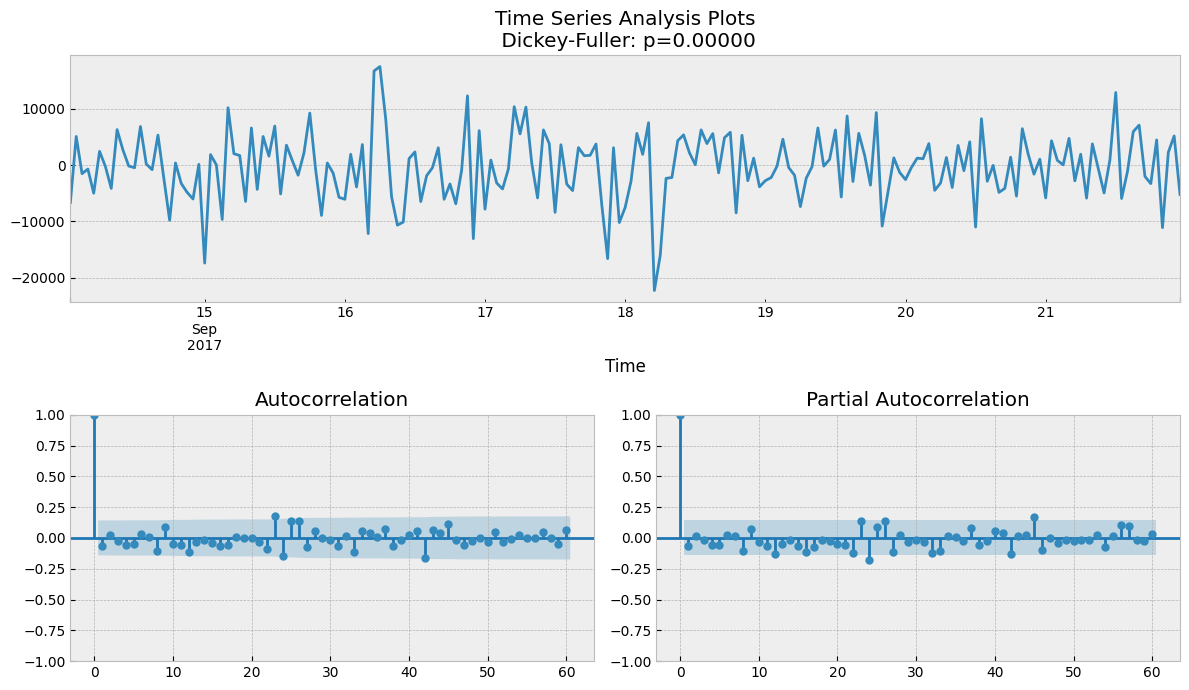

In [ ]:
tsplot(best_model.resid[24+1:], lags=60)

Остатки стационарны

In [ ]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values

        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future

    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN

    # forecasting on n_steps forward
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model._append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

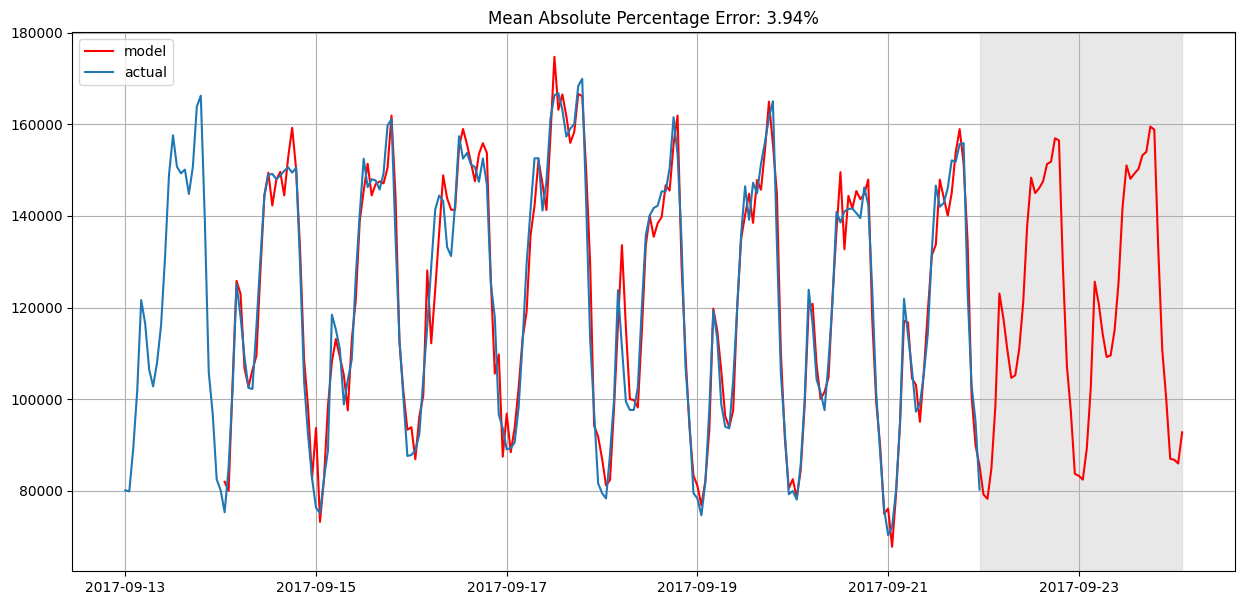

In [ ]:
plotSARIMA(ads, best_model, 50)

### Адаптация классических методов


#### Feature engineering

- Лаги
- Скользящие статистики
- Взвешенные скользящие статистики
- Групповые скользящие статистики
- Признаки даты/времени
- Тренд/сезонность как признаки
- …


##### Лаги

In [ ]:
# Creating a copy of the initial datagrame to make various transformations
data = pd.DataFrame(ads.Ads.copy())
data.columns = ["y"]

In [ ]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [ ]:
# take a look at the new dataframe
data.tail(7)

y     lag_6     lag_7     lag_8     lag_9    lag_10  \
Time                                                                            
2017-09-21 17:00:00  151790  132335.0  114380.0  105635.0   98860.0   97290.0   
2017-09-21 18:00:00  155665  146630.0  132335.0  114380.0  105635.0   98860.0   
2017-09-21 19:00:00  155890  141995.0  146630.0  132335.0  114380.0  105635.0   
2017-09-21 20:00:00  123395  142815.0  141995.0  146630.0  132335.0  114380.0   
2017-09-21 21:00:00  103080  146020.0  142815.0  141995.0  146630.0  132335.0   
2017-09-21 22:00:00   95155  152120.0  146020.0  142815.0  141995.0  146630.0   
2017-09-21 23:00:00   80285  151790.0  152120.0  146020.0  142815.0  141995.0   

                       lag_11    lag_12    lag_13    lag_14    lag_15  \
Time                                                                    
2017-09-21 17:00:00  106495.0  113950.0  121910.0   94945.0   80195.0   
2017-09-21 18:00:00   97290.0  106495.0  113950.0  121910.0   94945.0   
2017-09-21 19:00:00   98860.0   97290.0  106495.0  113950.0  121910.0   
2017-09-21 20:00:00  105635.0   98860.0   97290.0  106495.0  113950.0   
2017-09-21 21:00:00  114380.0  105635.0   98860.0   97290.0  106495.0   
2017-09-21 22:00:00  132335.0  114380.0  105635.0   98860.0   97290.0   
2017-09-21 23:00:00  146630.0  132335.0  114380.0  105635.0   98860.0   

                       lag_16    lag_17    lag_18    lag_19    lag_20  \
Time                                                                    
2017-09-21 17:00:00   72150.0   70335.0   76050.0   88170.0  101360.0   
2017-09-21 18:00:00   80195.0   72150.0   70335.0   76050.0   88170.0   
2017-09-21 19:00:00   94945.0   80195.0   72150.0   70335.0   76050.0   
2017-09-21 20:00:00  121910.0   94945.0   80195.0   72150.0   70335.0   
2017-09-21 21:00:00  113950.0  121910.0   94945.0   80195.0   72150.0   
2017-09-21 22:00:00  106495.0  113950.0  121910.0   94945.0   80195.0   
2017-09-21 23:00:00   97290.0  106495.0  113950.0  121910.0   94945.0   

                       lag_21    lag_22    lag_23    lag_24  
Time                                                         
2017-09-21 17:00:00  123945.0  142425.0  146215.0  139515.0  
2017-09-21 18:00:00  101360.0  123945.0  142425.0  146215.0  
2017-09-21 19:00:00   88170.0  101360.0  123945.0  142425.0  
2017-09-21 20:00:00   76050.0   88170.0  101360.0  123945.0  
2017-09-21 21:00:00   70335.0   76050.0   88170.0  101360.0  
2017-09-21 22:00:00   72150.0   70335.0   76050.0   88170.0  
2017-09-21 23:00:00   80195.0   72150.0   70335.0   76050.0

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """

    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [ ]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [ ]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies

    """

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train,
                                    cv=tscv,
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

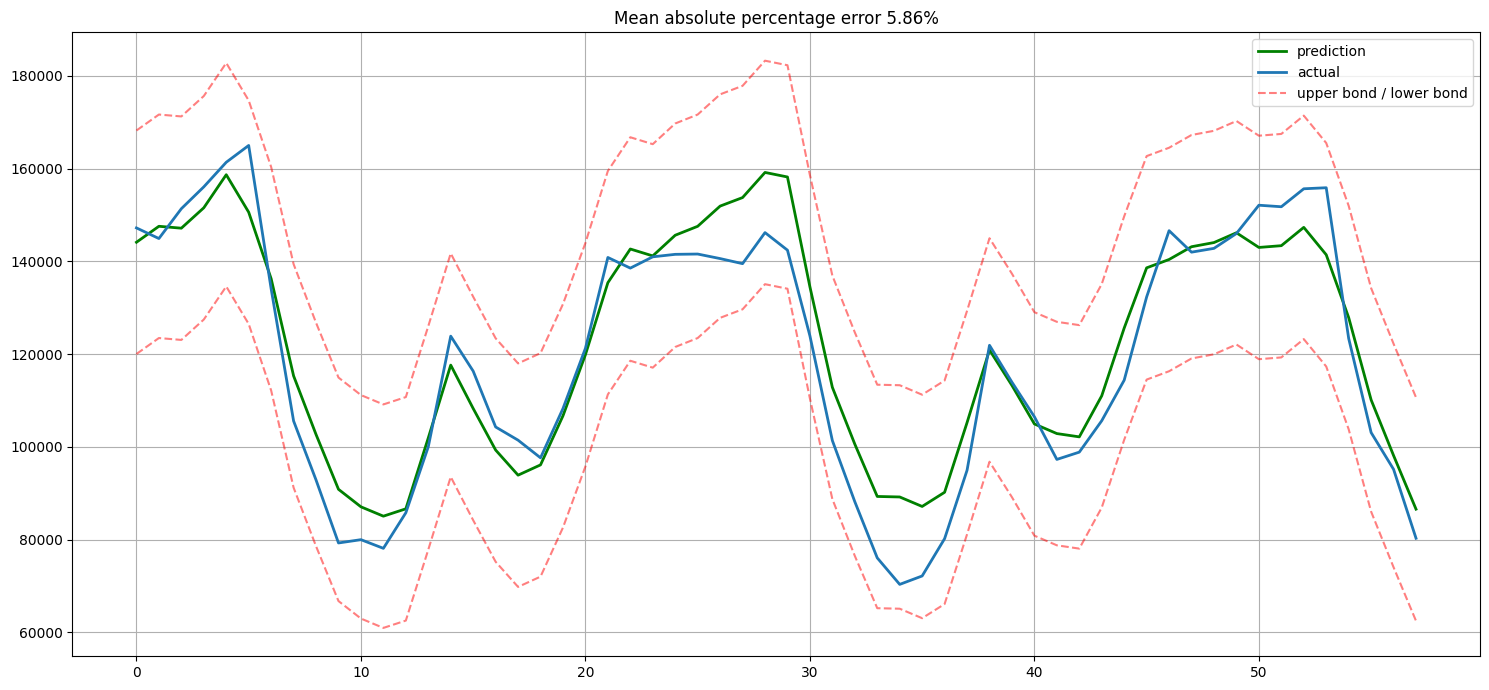

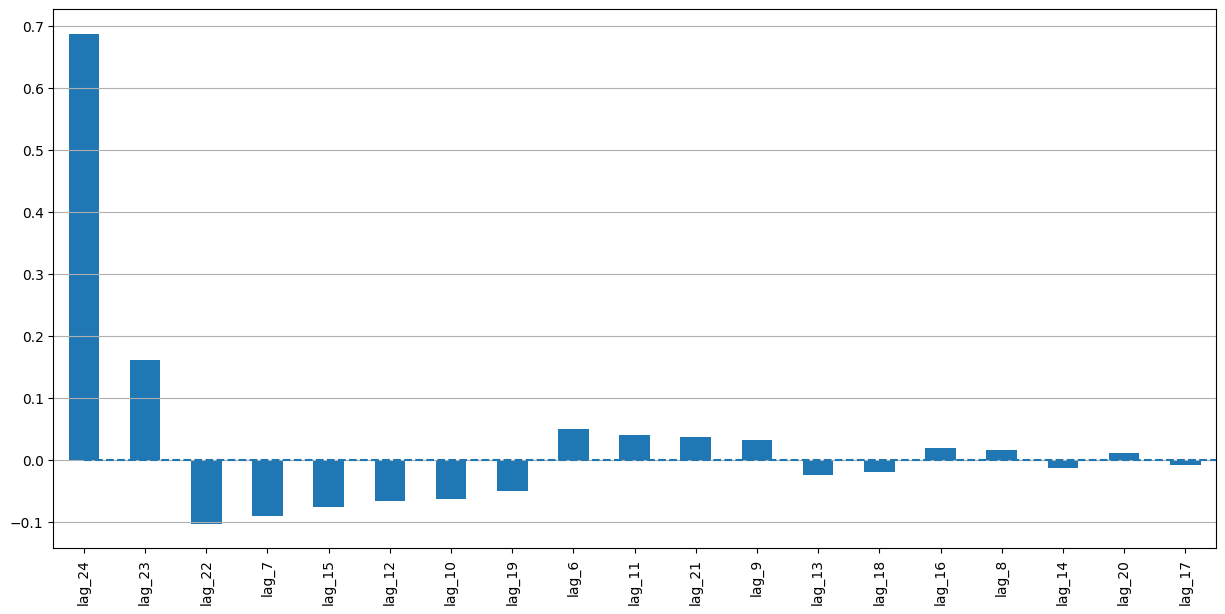

In [ ]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

#### Признаки из даты и времени

In [ ]:
data.index = pd.to_datetime(data.index)
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5, 6]) * 1
data.tail()

y     lag_6     lag_7     lag_8     lag_9    lag_10  \
Time                                                                            
2017-09-21 19:00:00  155890  141995.0  146630.0  132335.0  114380.0  105635.0   
2017-09-21 20:00:00  123395  142815.0  141995.0  146630.0  132335.0  114380.0   
2017-09-21 21:00:00  103080  146020.0  142815.0  141995.0  146630.0  132335.0   
2017-09-21 22:00:00   95155  152120.0  146020.0  142815.0  141995.0  146630.0   
2017-09-21 23:00:00   80285  151790.0  152120.0  146020.0  142815.0  141995.0   

                       lag_11    lag_12    lag_13    lag_14  ...    lag_18  \
Time                                                         ...             
2017-09-21 19:00:00   98860.0   97290.0  106495.0  113950.0  ...   72150.0   
2017-09-21 20:00:00  105635.0   98860.0   97290.0  106495.0  ...   80195.0   
2017-09-21 21:00:00  114380.0  105635.0   98860.0   97290.0  ...   94945.0   
2017-09-21 22:00:00  132335.0  114380.0  105635.0   98860.0  ...  121910.0   
2017-09-21 23:00:00  146630.0  132335.0  114380.0  105635.0  ...  113950.0   

                       lag_19   lag_20   lag_21    lag_22    lag_23    lag_24  \
Time                                                                            
2017-09-21 19:00:00   70335.0  76050.0  88170.0  101360.0  123945.0  142425.0   
2017-09-21 20:00:00   72150.0  70335.0  76050.0   88170.0  101360.0  123945.0   
2017-09-21 21:00:00   80195.0  72150.0  70335.0   76050.0   88170.0  101360.0   
2017-09-21 22:00:00   94945.0  80195.0  72150.0   70335.0   76050.0   88170.0   
2017-09-21 23:00:00  121910.0  94945.0  80195.0   72150.0   70335.0   76050.0   

                     hour  weekday  is_weekend  
Time                                            
2017-09-21 19:00:00    19        3           0  
2017-09-21 20:00:00    20        3           0  
2017-09-21 21:00:00    21        3           0  
2017-09-21 22:00:00    22        3           0  
2017-09-21 23:00:00    23        3           0  

[5 rows x 23 columns]

We can visualize the resulting features.

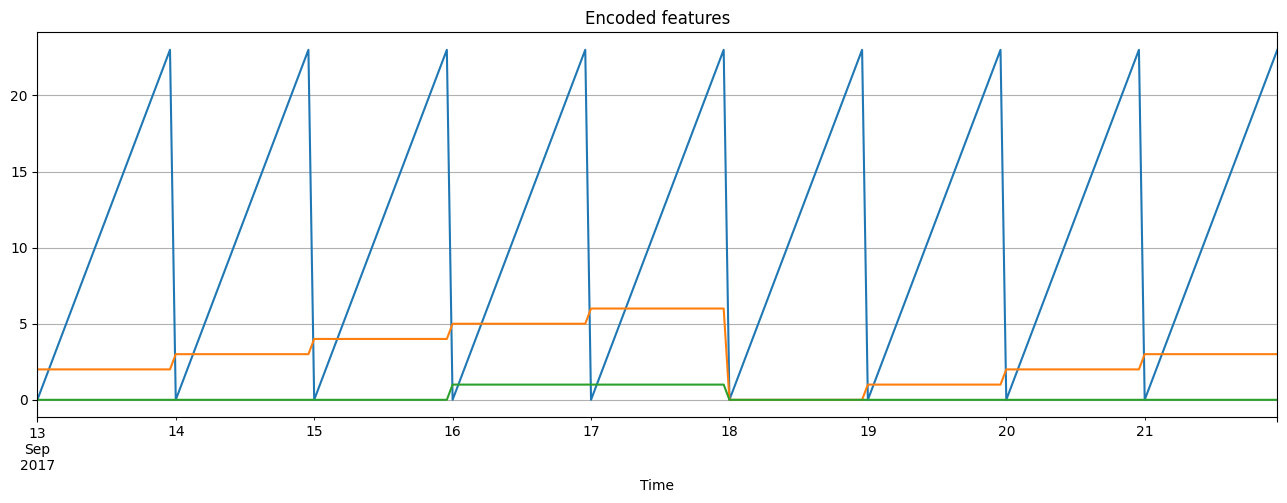

In [ ]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

Поскольку теперь у нас разные порядки значений признаков: тысячи для лагов и десятки для категориальных признаков, нам нужно преобразовать их в одну и ту же шкалу

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

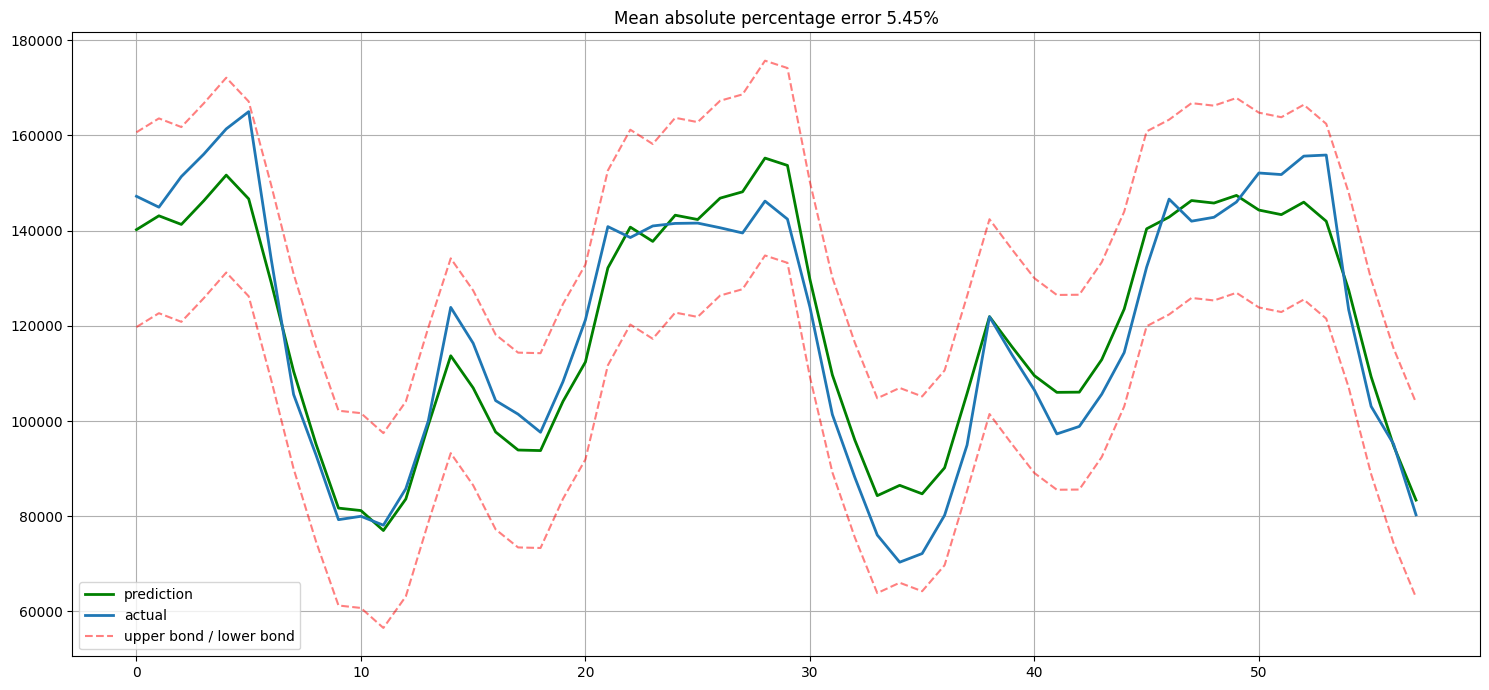

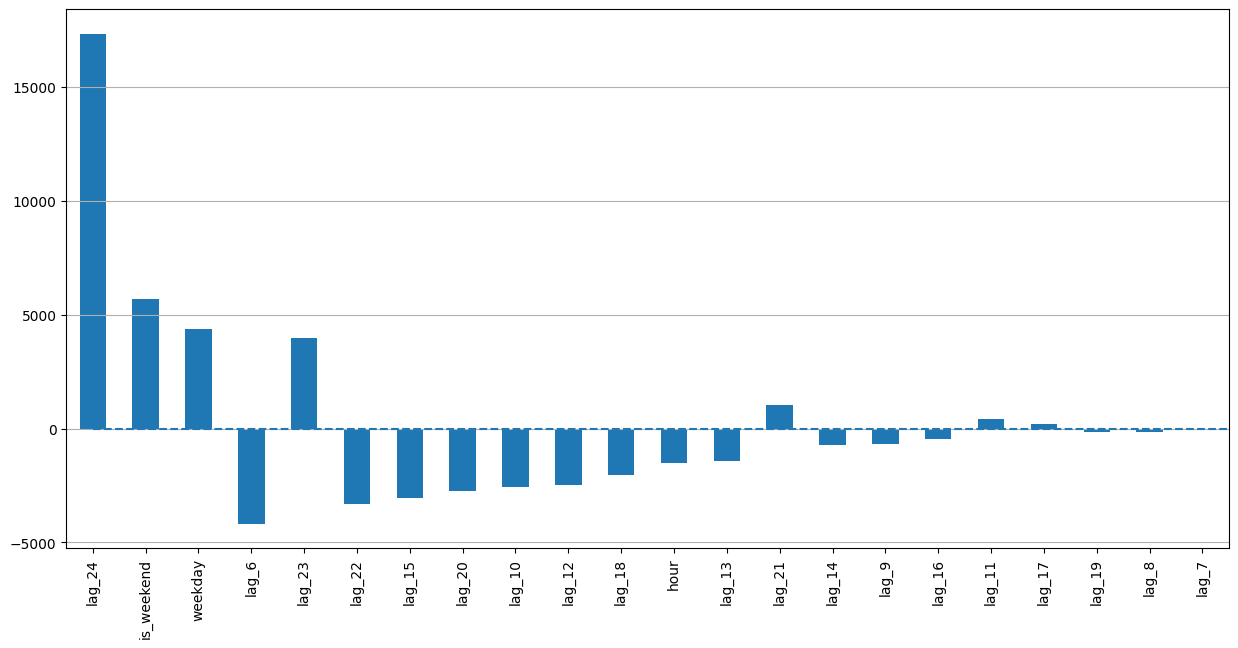

In [ ]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

## Регуляризация и отбор признаков в линейных моделях

Давайте вспомним, какая регуляризация бывает и зачем она нужна?

А как все это связано с отбором признаков?

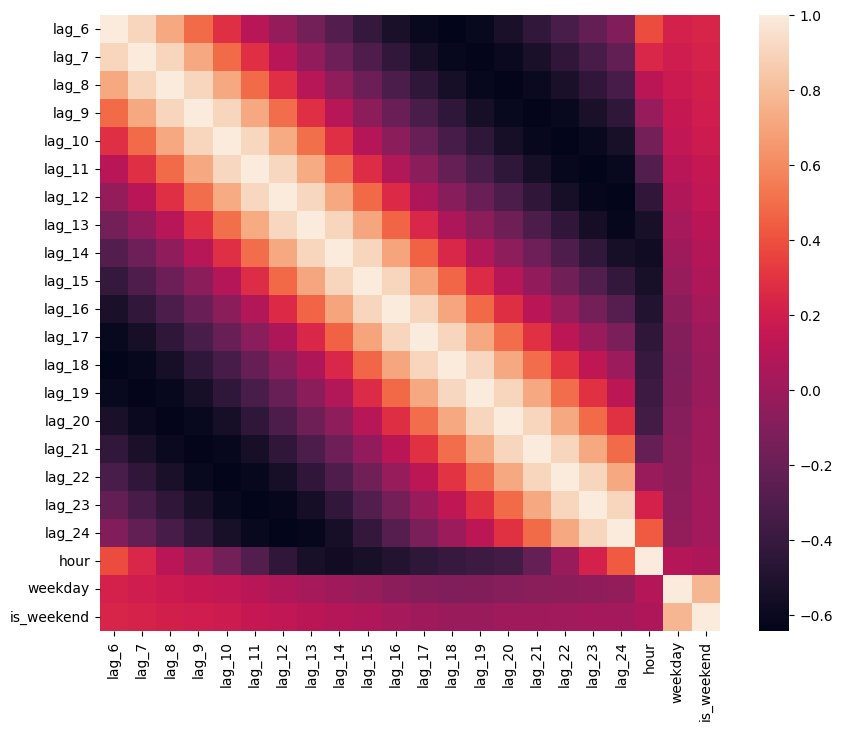

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

#### Ridge

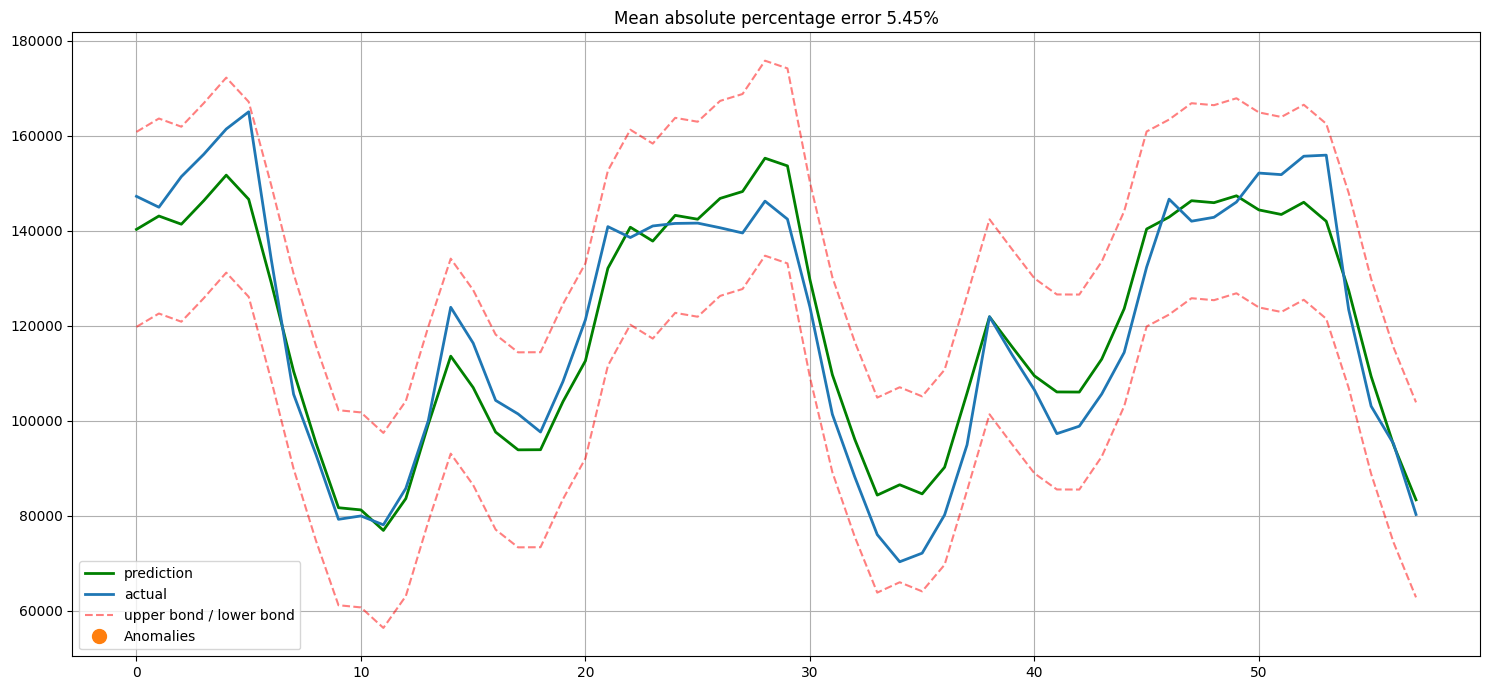

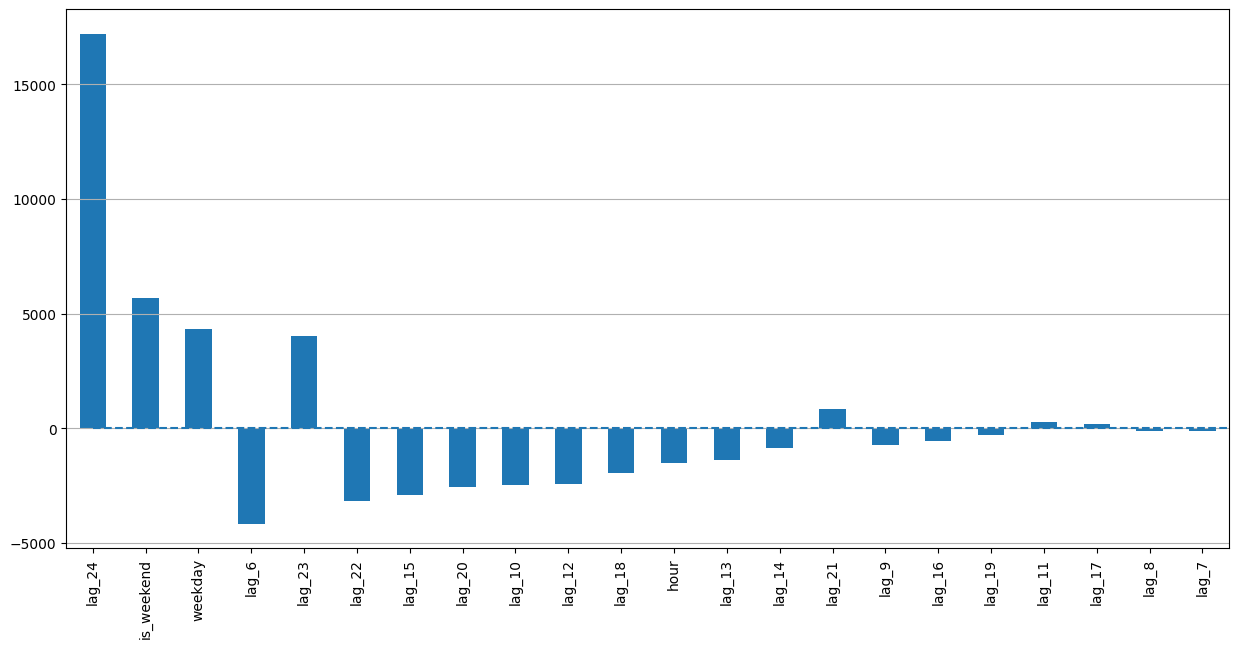

In [ ]:
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge

ridge = RidgeCV(cv=tscv, alphas=np.linspace(0.1, 1, 10))
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge,
                 X_train=X_train_scaled,
                 X_test=X_test_scaled,
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

#### Lasso

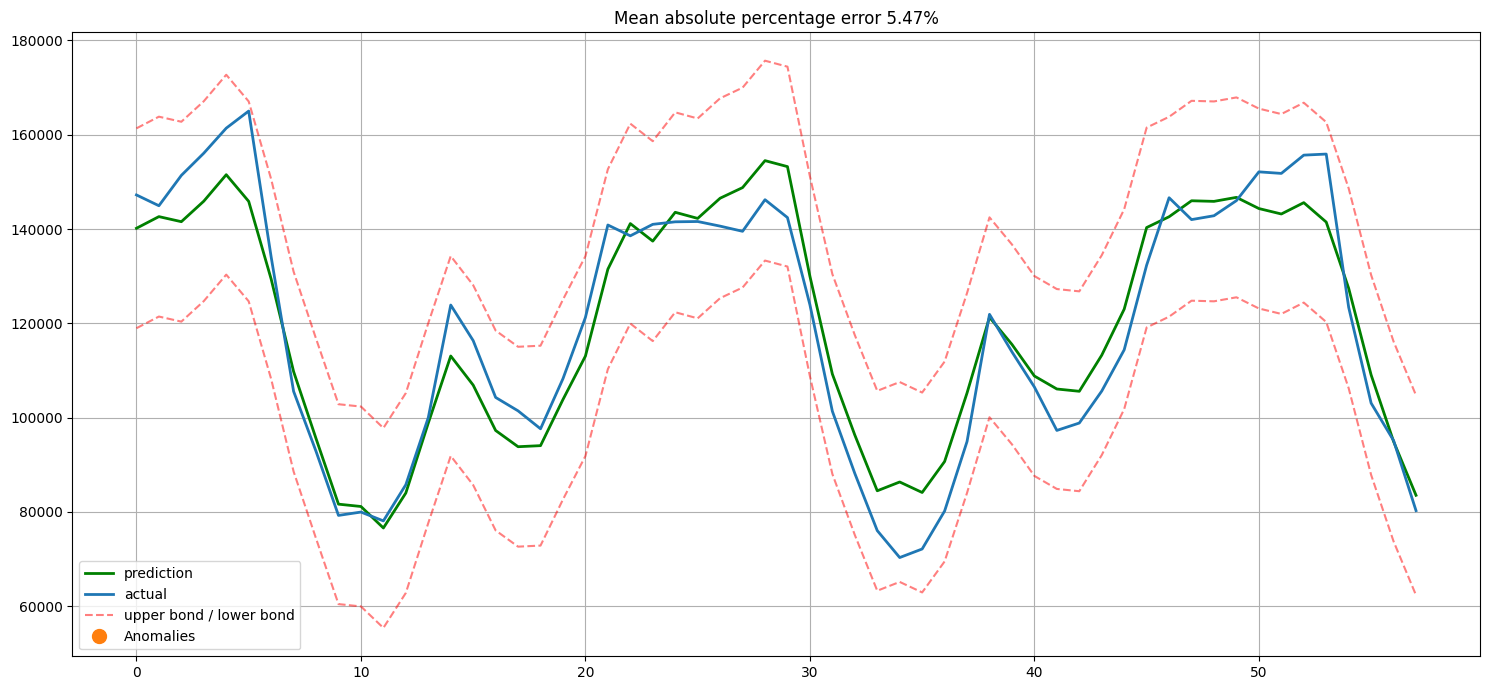

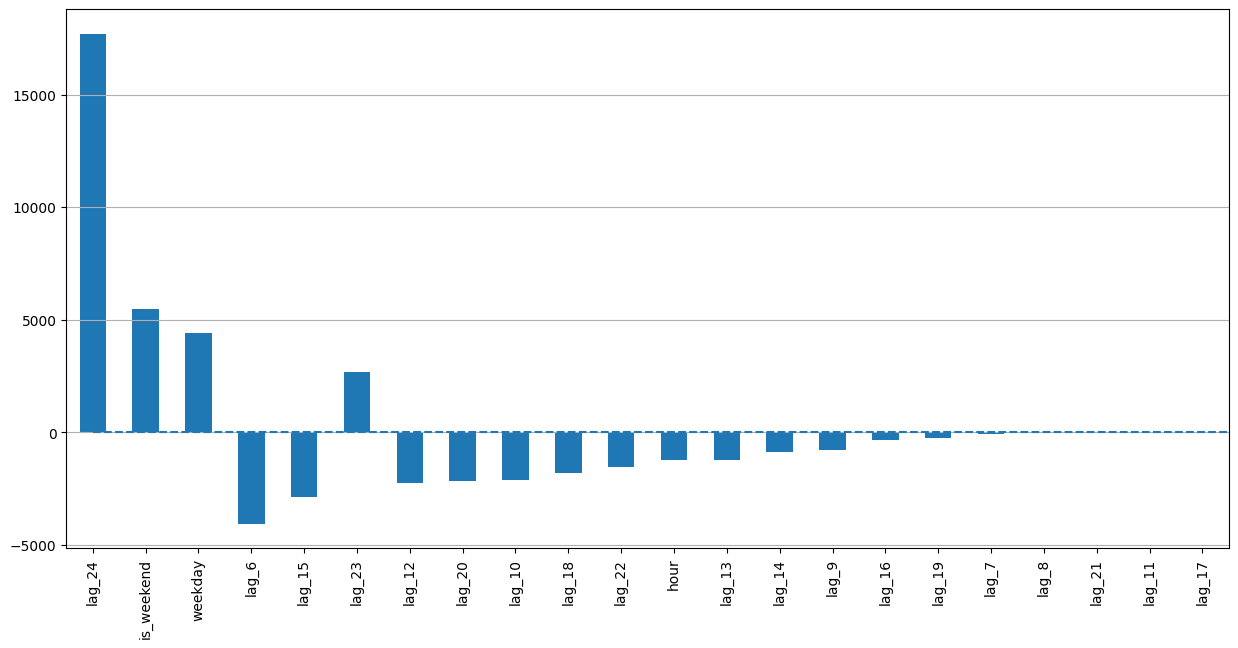

In [ ]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso,
                 X_train=X_train_scaled,
                 X_test=X_test_scaled,
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

## А что там у деревьев?

### Случайный лес

In [ ]:
from sklearn.ensemble import RandomForestRegressor

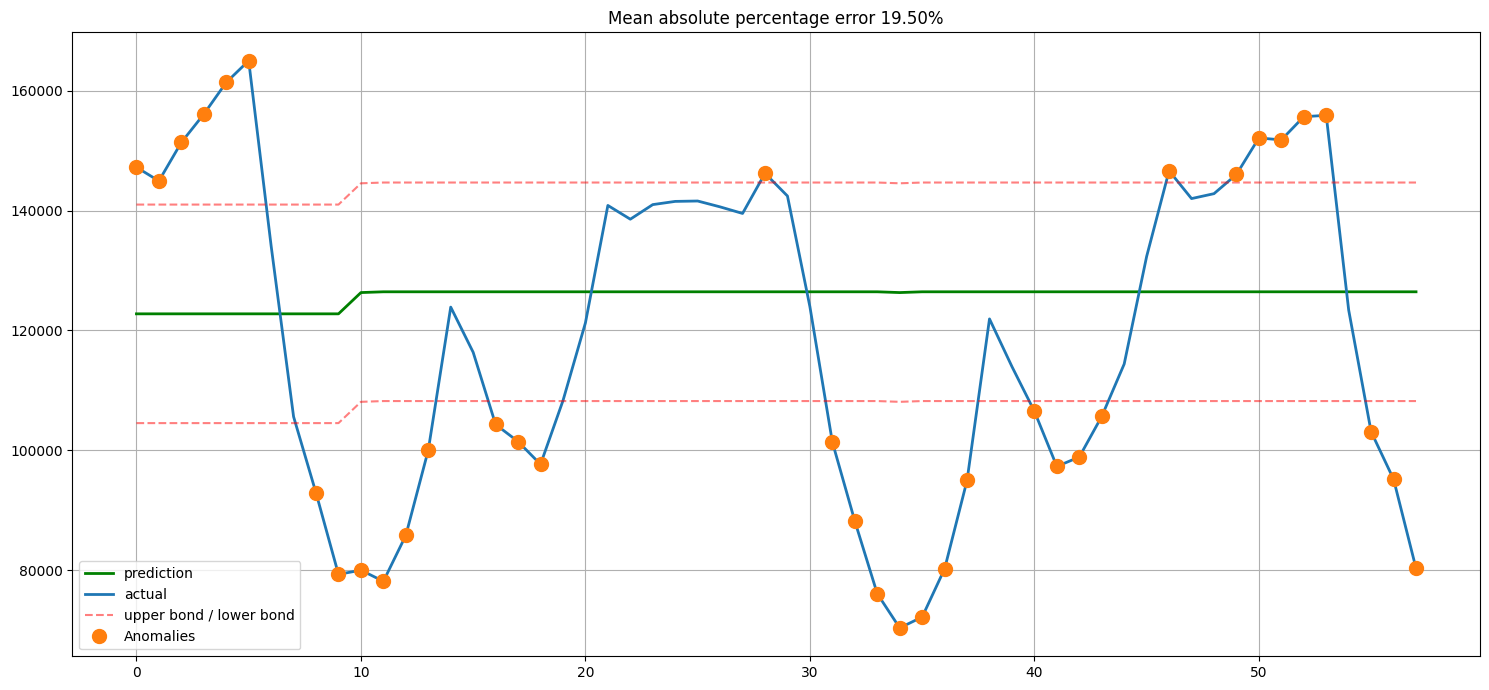

In [ ]:
rf = RandomForestRegressor(random_state=2024)
rf.fit(X_train_scaled, y_train)

plotModelResults(rf, X_train=X_train, X_test=X_test, plot_intervals=True, plot_anomalies=True)

**?!**

Попробуем подобрать гиперпараметры

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
%%time

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
gs = GridSearchCV(rf, param_grid, cv=tscv, n_jobs=-1)
gs.fit(X_train, y_train)

CPU times: user 25.1 s, sys: 991 ms, total: 26.1 s
Wall time: 3min 21s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=2024), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150, 200]})

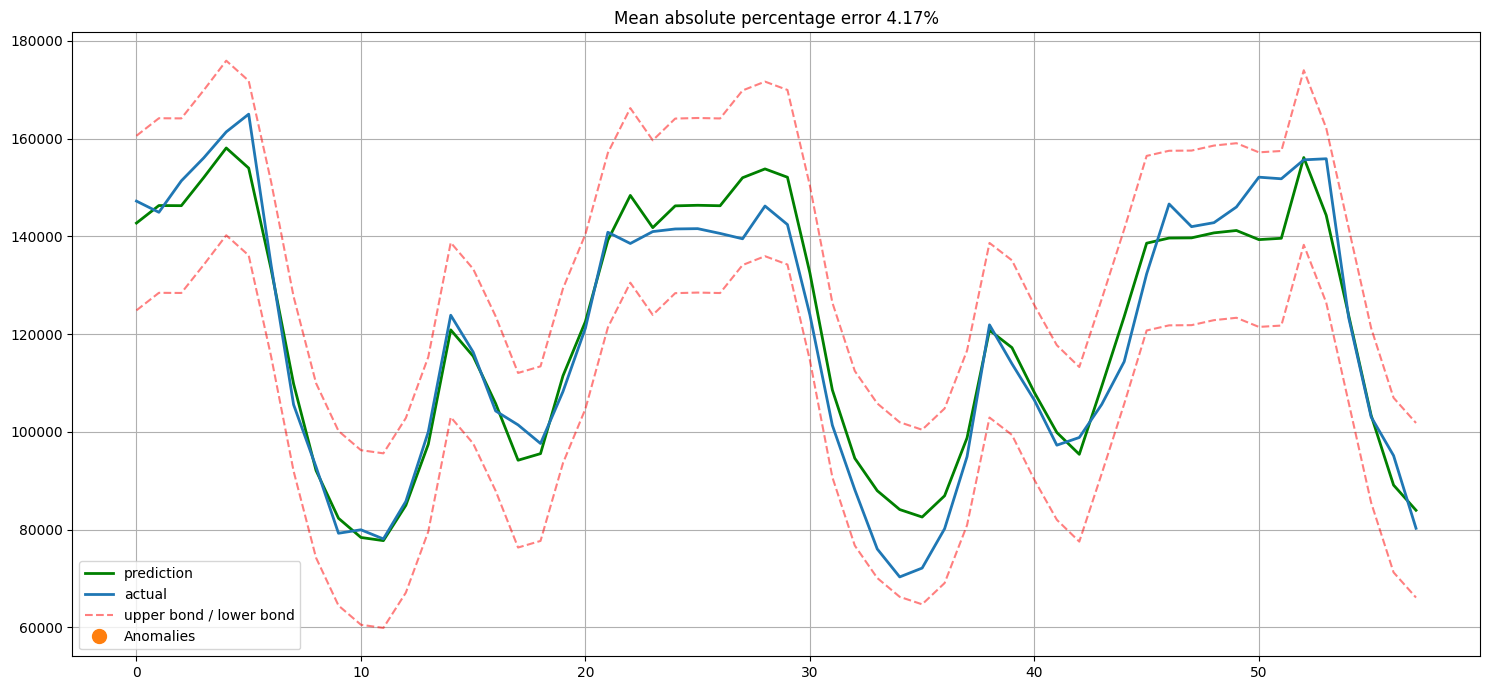

In [ ]:
plotModelResults(gs.best_estimator_, X_train=X_train, X_test=X_test, plot_intervals=True, plot_anomalies=True)

### Бустинг

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
catboost_model = CatBoostRegressor(random_seed=42, logging_level='Silent')
catboost_model.fit(X_train, y_train, plot=False)

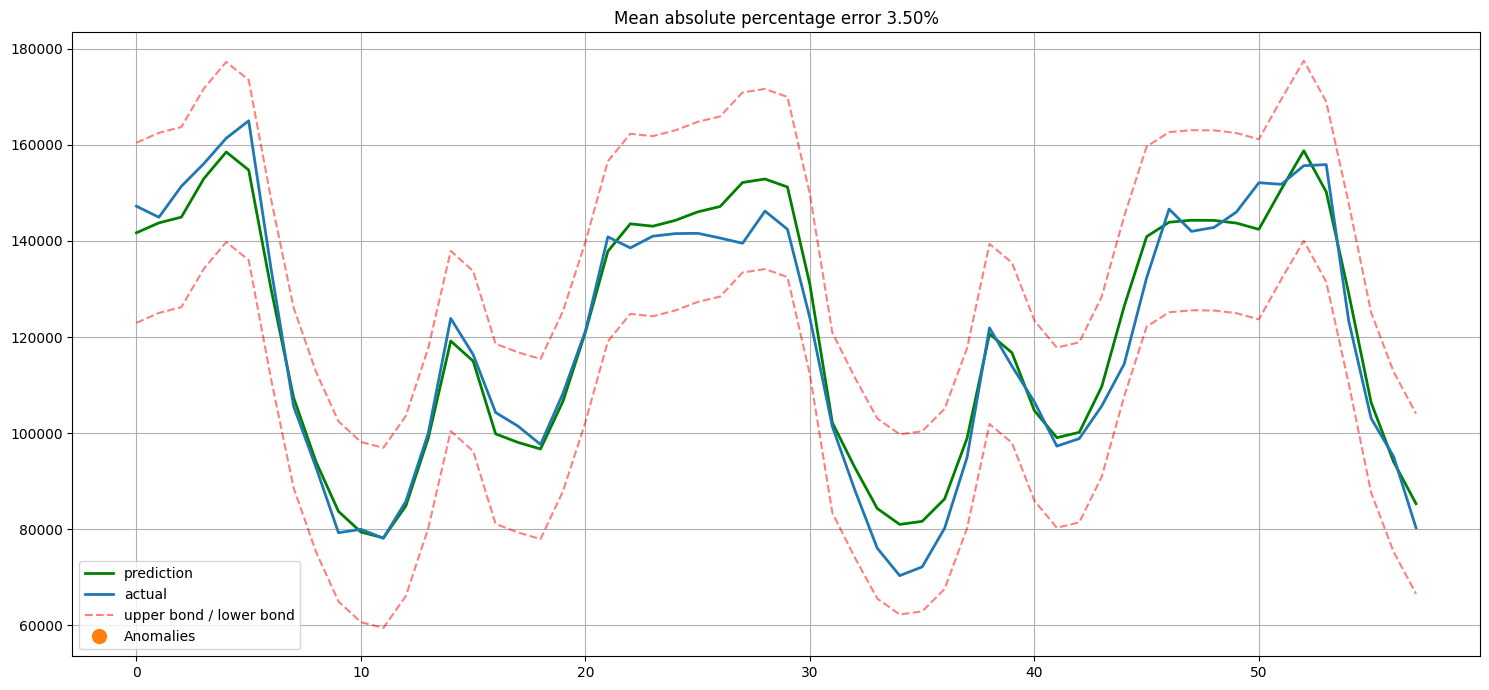

In [ ]:
plotModelResults(catboost_model, X_train=X_train, X_test=X_test, plot_intervals=True, plot_anomalies=True)

In [ ]:
mean_absolute_percentage_error(gs.best_estimator_.predict(X_train), y_train)

3.1101190135760097

In [ ]:
mean_absolute_percentage_error(gs.best_estimator_.predict(X_test), y_test)

5.444380954896263

In [ ]:
%%time

param_grid = {
    'colsample_bylevel': np.linspace(0.01, 0.1, 10),
    'depth': [1, 2, 3, 4, 5],
    'boosting_type': ["Ordered", "Plain"],
    'bootstrap_type': ["Bayesian", "Bernoulli", "MVS"],
    'eval_metric': ['MAPE']
}
catboost_model = CatBoostRegressor(random_seed=42, logging_level='Silent')
gs = GridSearchCV(catboost_model, param_grid, cv=tscv, n_jobs=-1)
gs.fit(X_train, y_train)

CPU times: user 9.12 s, sys: 788 ms, total: 9.91 s
Wall time: 6min 35s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7eac01e221a0>,
             n_jobs=-1,
             param_grid={'boosting_type': ['Ordered', 'Plain'],
                         'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
                         'colsample_bylevel': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                         'depth': [1, 2, 3, 4, 5], 'eval_metric': ['MAPE']})

In [ ]:
results_df = pd.DataFrame(gs.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

params  \
kernel                                                                                         
Ordered_Bayesian_0.07_2_MAPE               {'boosting_type': 'Ordered', 'bootstrap_type':...   
Plain_Bayesian_0.09000000000000001_2_MAPE  {'boosting_type': 'Plain', 'bootstrap_type': '...   
Plain_Bayesian_0.09000000000000001_3_MAPE  {'boosting_type': 'Plain', 'bootstrap_type': '...   
Ordered_Bayesian_0.07_3_MAPE               {'boosting_type': 'Ordered', 'bootstrap_type':...   
Plain_Bayesian_0.1_2_MAPE                  {'boosting_type': 'Plain', 'bootstrap_type': '...   
...                                                                                      ...   
Ordered_Bernoulli_0.01_1_MAPE              {'boosting_type': 'Ordered', 'bootstrap_type':...   
Ordered_Bernoulli_0.01_2_MAPE              {'boosting_type': 'Ordered', 'bootstrap_type':...   
Plain_Bayesian_0.01_1_MAPE                 {'boosting_type': 'Plain', 'bootstrap_type': '...   
Ordered_MVS_0.01_2_MAPE                    {'boosting_type': 'Ordered', 'bootstrap_type':...   
Ordered_Bayesian_0.01_1_MAPE               {'boosting_type': 'Ordered', 'bootstrap_type':...   

                                           rank_test_score  mean_test_score  \
kernel                                                                        
Ordered_Bayesian_0.07_2_MAPE                             1         0.756388   
Plain_Bayesian_0.09000000000000001_2_MAPE                2         0.756249   
Plain_Bayesian_0.09000000000000001_3_MAPE                3         0.754447   
Ordered_Bayesian_0.07_3_MAPE                             4         0.752546   
Plain_Bayesian_0.1_2_MAPE                                5         0.752258   
...                                                    ...              ...   
Ordered_Bernoulli_0.01_1_MAPE                          296         0.580046   
Ordered_Bernoulli_0.01_2_MAPE                          297         0.575456   
Plain_Bayesian_0.01_1_MAPE                             298         0.570826   
Ordered_MVS_0.01_2_MAPE                                299         0.569463   
Ordered_Bayesian_0.01_1_MAPE                           300         0.566622   

                                           std_test_score  
kernel                                                     
Ordered_Bayesian_0.07_2_MAPE                     0.170061  
Plain_Bayesian_0.09000000000000001_2_MAPE        0.179626  
Plain_Bayesian_0.09000000000000001_3_MAPE        0.170541  
Ordered_Bayesian_0.07_3_MAPE                     0.181129  
Plain_Bayesian_0.1_2_MAPE                        0.187952  
...                                                   ...  
Ordered_Bernoulli_0.01_1_MAPE                    0.185553  
Ordered_Bernoulli_0.01_2_MAPE                    0.176858  
Plain_Bayesian_0.01_1_MAPE                       0.175977  
Ordered_MVS_0.01_2_MAPE                          0.175762  
Ordered_Bayesian_0.01_1_MAPE                     0.198308  

[300 rows x 4 columns]

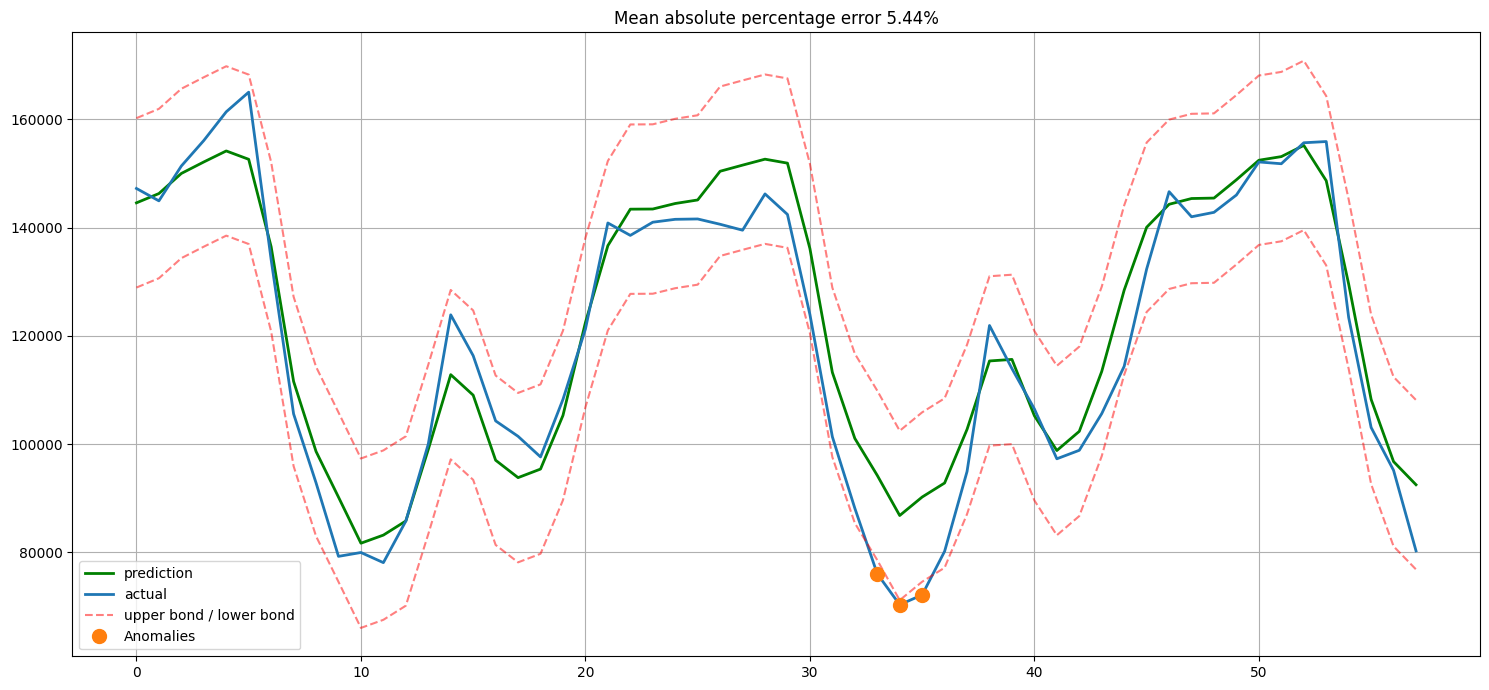

In [ ]:
plotModelResults(gs.best_estimator_, X_train=X_train, X_test=X_test, plot_intervals=True, plot_anomalies=True)

In [ ]:
!pip install optuna optuna-integration[catboost]

In [ ]:
import numpy as np
import optuna
from optuna.integration import CatBoostPruningCallback

In [ ]:
def objective(trial: optuna.Trial) -> float:
  n = len(X_train)
  train_size = int(n * 0.8)
  X_train_small, X_val, y_train_small, y_val = X_train.iloc[:train_size], X_train.iloc[train_size:], y_train.iloc[:train_size], y_train.iloc[train_size:]

  param = {
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 5),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "eval_metric": "MAPE",
  }

  if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
  elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

  gbm = CatBoostRegressor(**param)

  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
  gbm.fit(
        X_train_small,
        y_train_small,
        eval_set=[(X_val, y_val)],
        verbose=0,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
  )

    # evoke pruning manually.
  pruning_callback.check_pruned()

  preds = gbm.predict(X_val)
  mape = mean_absolute_percentage_error(preds, y_val)

  return mape

In [ ]:
study = optuna.create_study(
      pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="minimize"
)
study.optimize(objective, n_trials=100, timeout=300)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-09-25 20:05:01,387] A new study created in memory with name: no-name-7f40af8e-970c-4564-8771-282c76d94178
[I 2024-09-25 20:05:04,377] Trial 0 finished with value: 6.343675639053116 and parameters: {'colsample_bylevel': 0.026629602814379646, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.16569218350741757}. Best is trial 0 with value: 6.343675639053116.
[I 2024-09-25 20:05:07,797] Trial 1 finished with value: 9.305661626012755 and parameters: {'colsample_bylevel': 0.01023695141919454, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.779579620437656}. Best is trial 0 with value: 6.343675639053116.
[I 2024-09-25 20:05:10,238] Trial 2 finished with value: 7.476402873701185 and parameters: {'colsample_bylevel': 0.016357488760607747, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3619126072641107}. Best is trial 0 with value: 6.343675639053116.
[I 2024-09-25 20:05:11,

Number of finished trials: 100
Best trial:
  Value: 4.711518976172711
  Params: 
    colsample_bylevel: 0.09998379125688778
    depth: 2
    boosting_type: Ordered
    bootstrap_type: MVS


In [ ]:
catboost_model = CatBoostRegressor(random_seed=42, logging_level='Silent', **trial.params)
catboost_model.fit(X_train, y_train, plot=False)

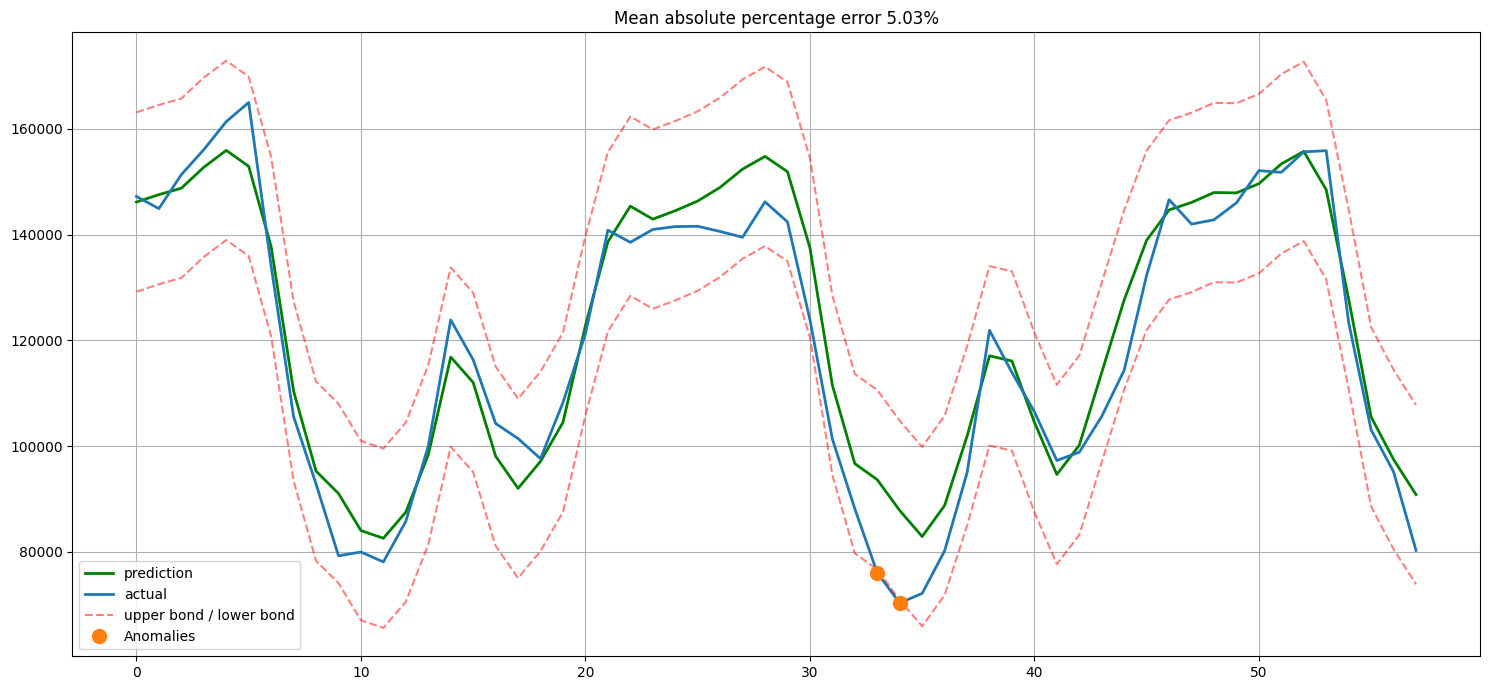

In [ ]:
plotModelResults(catboost_model, X_train=X_train, X_test=X_test, plot_intervals=True, plot_anomalies=True)